## Benchmarking and Comparision

Think I have the ha-model all worked out and effecient. Here are some points of comparison and benchmarks. 

**lessons learned** In doing this I learnead even more in Julia. A key issue that came up regards (i) minnimizing even small allocations in places of the code that are called all the time (i.e. in the itteration part) and (ii) often explicit loops are faster, more memory effecient than broadcasting.

In [23]:
include("ha-trade-environment.jl")
include("ha-trade-solution.jl")
include("ha-trade-helper-functions.jl")

using Plots

Threads.nthreads()

12

Here is one itteration on the colemen operator. 

Parameters here were selected to match up with Huggett economy in closed economy case. Also, per the notes, only is the log case where logit = ces. So baseline should be with $\gamma = 1$.

In [17]:
mdl_prm = model_params(Ncntry = 5, Na = 100, Nshocks = 5, γ = 3.0, ϕ = 3, amax = 8.0, σ = 0.3919, ρ = 0.20);

@unpack Na, Nshocks, Ncntry, β = mdl_prm

gc = repeat(range(0.1,3,Na),1,Nshocks,Ncntry)

v = -ones(size(gc)) / (1- β)

country = 1

p = 1.5.*ones(Ncntry)

p[country] = 1.0

R = 1.029;
W = 1.0;

@time Kg, Tv, aprime = coleman_operator(gc, v, R, W, p, mdl_prm);

  0.003635 seconds (371 allocations: 266.859 KiB)


In [18]:
Kg[:, :, 1]

100×5 Matrix{Float64}:
 0.134689  0.19088   0.293265  0.479818  0.81973
 0.160634  0.216826  0.319211  0.505764  0.845676
 0.18658   0.242772  0.345157  0.53171   0.871622
 0.212526  0.268718  0.371103  0.557656  0.897567
 0.238472  0.294663  0.397049  0.583601  0.923513
 0.264418  0.320609  0.422994  0.609547  0.949459
 0.290363  0.346555  0.44894   0.635493  0.975405
 0.316309  0.372501  0.474886  0.661439  1.00135
 0.342255  0.398447  0.500832  0.687385  1.0273
 0.368201  0.424392  0.526778  0.71333   1.05324
 0.394146  0.450338  0.552723  0.739276  1.07919
 0.420092  0.476284  0.578669  0.765222  1.10513
 0.446038  0.50223   0.604615  0.791168  1.13108
 ⋮                                       
 2.41792   2.47411   2.5765    2.76305   3.10296
 2.44386   2.50006   2.60244   2.78899   3.12891
 2.46981   2.526     2.62839   2.81494   3.15485
 2.49576   2.55195   2.65433   2.84089   3.1808
 2.5217    2.57789   2.68028   2.86683   3.20674
 2.54765   2.60384   2.70622   2.89278   3.23269


Then this solves the household problem. Note that while itteraiton solution method is slightly slower, the memory allocation is far lower and usually the garbage collector is not triggerd. This suggests that for a "large" system with many countries, it's a perferred approach.

In [19]:
@time hh = solve_household_problem(R, W, p, mdl_prm, solution_method = "itteration");

  0.527188 seconds (66.12 k allocations: 47.121 MiB)


In [20]:
hh.asset_policy[:,:,1]

100×5 Matrix{Float64}:
 -3.0      -3.0      -2.80113  -2.13303   -0.750933
 -3.0      -2.97252  -2.71646  -2.02988   -0.6425
 -3.0      -2.91502  -2.62719  -1.92594   -0.533915
 -2.95572  -2.84876  -2.53432  -1.82133   -0.42519
 -2.90156  -2.77481  -2.4381   -1.71615   -0.316336
 -2.83611  -2.69067  -2.33994  -1.61049   -0.20736
 -2.76533  -2.60282  -2.24004  -1.5044    -0.0982726
 -2.68415  -2.51119  -2.13885  -1.39793    0.0109182
 -2.59861  -2.41631  -2.03664  -1.29112    0.120206
 -2.50911  -2.31946  -1.93353  -1.18402    0.229584
 -2.41609  -2.22068  -1.82964  -1.07664    0.339046
 -2.32093  -2.12027  -1.72509  -0.969026   0.448588
 -2.22347  -2.01879  -1.61998  -0.86119    0.558203
  ⋮                                       
  6.05182   6.28446   6.70846   7.46319    8.0
  6.1619    6.39419   6.81706   7.56406    8.0
  6.2719    6.50374   6.92547   7.66558    8.0
  6.38183   6.61313   7.03373   7.76805    8.0
  6.49164   6.72235   7.14162   7.86507    8.0
  6.6013    6.83137   7.2

Now here are the choice probabilies for hh in country 1. Notice that those with low incomes, low assets purchase far more from home (the cheap good). This is exactly the "want operator" I was looking for.

In [21]:
hh.πprob[:,:,1]

100×5 Matrix{Float64}:
 1.0       0.999968  0.935712  0.763639  0.63925
 1.0       0.997707  0.905405  0.750708  0.633672
 0.999988  0.986877  0.880148  0.738752  0.628305
 0.998752  0.973466  0.857864  0.727575  0.62314
 0.994791  0.949192  0.835353  0.717116  0.618155
 0.984848  0.924419  0.814268  0.707411  0.613325
 0.964942  0.896795  0.797328  0.698362  0.608652
 0.944022  0.874424  0.781935  0.689847  0.604134
 0.918588  0.852023  0.76782   0.681859  0.599762
 0.894994  0.831365  0.754807  0.674447  0.595522
 0.872483  0.813244  0.742632  0.667427  0.591405
 0.851339  0.795897  0.731229  0.660727  0.587401
 0.832084  0.78128   0.720693  0.654325  0.583506
 ⋮                                       
 0.467948  0.460725  0.448469  0.423684  0.286726
 0.465847  0.458541  0.446011  0.419772  0.277808
 0.463732  0.456333  0.443503  0.415418  0.270214
 0.461601  0.454091  0.440953  0.410695  0.263695
 0.459452  0.451808  0.438337  0.405947  0.258055
 0.457278  0.449473  0.435649  0.4008

  0.390758 seconds (56.46 k allocations: 416.929 MiB, 12.33% gc time)


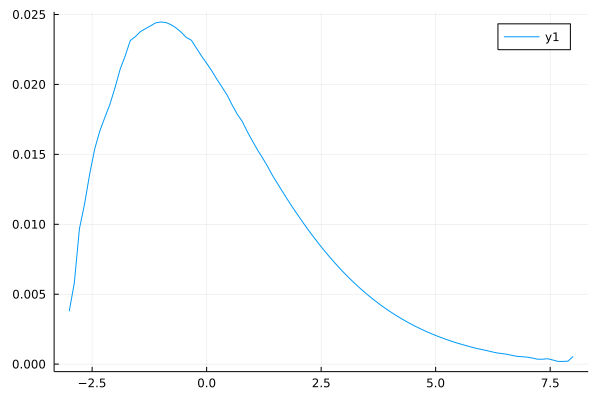

In [28]:
@time hh, dist = compute_eq(R, W, p, mdl_prm);

asset_dist = get_distribution(dist.state_index, dist.λ);

plot(mdl_prm.agrid, asset_dist)

---

#### Now multi-country and aggregate

So solve for everyting (hh problem, stationary distribution, aggregate) for fixed prices. Still no market clearing.

In [12]:
Ncntry = 5

# this sets up the trade costs the way I want them

d = 1.5.*ones(Ncntry,Ncntry)
d[diagind(d)] .= 1.0

mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, Nshocks = 5, 
γ = 3.0, ϕ = 3, amax = 8.0, σ = 0.3919, ρ = 0.20, d = d)

@unpack Ncntry = mdl_prm

R = 1.029*ones(Ncntry);
W = 1.0*ones(Ncntry);

@time Y, tradeflows, Ademand = world_equillibrium(R, W, mdl_prm, hh_solution_method = "itteration")

  0.591153 seconds (459.63 k allocations: 254.473 MiB)


([1.1000045931566682, 1.1000045931566647, 1.1000045931566667, 1.1000045931566653, 1.1000045931566649], [0.6239525627364122 0.12003688587642078 … 0.12003705402346221 0.12003713717276931; 0.12003601414345845 0.6239526832147222 … 0.12003731827331868 0.1200374685489377; … ; 0.12003137327727702 0.12003175715874448 … 0.6239634074953169 0.12003487118726627; 0.12003270926339762 0.12003283267446441 … 0.12003307681438515 0.6239621811649959], [0.14124197938150118, 0.14124339326420832, 0.14124142781103605, 0.14099843467888395, 0.14100559818422065])

And here are the trade flows...

In [13]:
tradeflows

5×5 Matrix{Float64}:
 0.623953  0.120037  0.120037  0.120037  0.120037
 0.120036  0.623953  0.120037  0.120037  0.120037
 0.120034  0.120034  0.623954  0.120039  0.120039
 0.120031  0.120032  0.120032  0.623963  0.120035
 0.120033  0.120033  0.120033  0.120033  0.623962

Note things are not exactly symmetric. Note sure why, one thought is because of the upwind method and itterations are ordered always the same, so number of times things are itterated on across country pairs is not the same. Also note in the benchmarking, 5 countries is solving just as fast as one hh problem above, garbage collection appears not to be triggerd. So the multi-threading on countries is working well.

Here is the big model, 20 countries. 

In [15]:
Ncntry = 20

# this sets up the trade costs the way I want them

d = 1.5.*ones(Ncntry,Ncntry)
d[diagind(d)] .= 1.0

mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, Nshocks = 5, 
γ = 3.0, ϕ = 3, amax = 8.0, σ = 0.3919, ρ = 0.20, d = d)

@unpack Ncntry = mdl_prm

R = 1.029*ones(Ncntry);
W = 1.0*ones(Ncntry);

@time Y, tradeflows, Ademand = world_equillibrium(R, W, mdl_prm, hh_solution_method = "itteration")

 11.096264 seconds (6.70 M allocations: 3.105 GiB, 9.95% gc time)


([1.1000045931566675, 1.1000045931566682, 1.1000045931566629, 1.1000045931566513, 1.1000045931566624, 1.1000045931566675, 1.100004593156667, 1.100004593156668, 1.1000045931566655, 1.1000045931566562, 1.1000045931566689, 1.1000045931566589, 1.1000045931566622, 1.1000045931566644, 1.100004593156667, 1.1000045931566618, 1.1000045931566707, 1.100004593156668, 1.1000045931566693, 1.1000045931566589], [0.3138123636413953 0.04141137007959771 … 0.0414115052251208 0.04141151297350902; 0.0414112932155714 0.3138121697298712 … 0.041411537398466335 0.04141154634157743; … ; 0.041410397403814525 0.041410411451270265 … 0.3138225458972755 0.04141076663201146; 0.04141043026362295 0.04141044208921986 … 0.04141063813924038 0.31382245087610383], [0.02155683290111866, 0.021561807811420697, 0.02155736096099087, 0.021560003570885108, 0.0215610617800829, 0.021560016239838442, 0.021556219802643883, 0.021556879805055235, 0.021560165864896348, 0.0215539689328497, 0.021546708431383458, 0.02152080839181552, 0.02137

In [16]:
tradeflows

20×20 Matrix{Float64}:
 0.313812   0.0414114  0.0414114  …  0.0414115  0.0414115  0.0414115
 0.0414113  0.313812   0.0414114     0.0414115  0.0414115  0.0414115
 0.0414113  0.0414113  0.313812      0.0414115  0.0414115  0.0414115
 0.0414113  0.0414113  0.0414113     0.0414115  0.0414116  0.0414116
 0.0414112  0.0414113  0.0414113     0.0414116  0.0414116  0.0414116
 0.0414112  0.0414112  0.0414112  …  0.0414116  0.0414116  0.0414116
 0.0414112  0.0414112  0.0414112     0.0414116  0.0414116  0.0414116
 0.0414111  0.0414111  0.0414111     0.0414117  0.0414117  0.0414117
 0.041411   0.041411   0.0414111     0.0414118  0.0414118  0.0414118
 0.0414108  0.0414109  0.0414109     0.0414119  0.0414119  0.0414119
 0.0414105  0.0414106  0.0414106  …  0.0414121  0.0414122  0.0414123
 0.0414095  0.0414097  0.0414098     0.0414128  0.0414129  0.0414131
 0.041403   0.0414036  0.0414042     0.0414175  0.0414181  0.0414186
 0.0414087  0.0414088  0.0414089     0.0414119  0.0414121  0.0414122
 0.0414098 

So this is good. 20 countries on 100 asset grid ~ 11 seconds, memory is not crazy. Again a key issue was getting memory allocations under control especially with the multi-threading where high memory allocation situations seemed to be problematic. 